# Plot the cyclone-centered PTE maps at selected time steps from CTL at 80km

In [2]:
exp='channel_80km_0001'
dt = 6
data_res  = '1x1latlon'
if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'
        
p2level=50

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import psutil
import datetime
import time as tm
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")

In [5]:
#####################################################
# Read in cyclone-centered PTE data from file
#####################################################

# path on Levante for the PTE calculated results (2D maps for all selected time steps)
ipath = "/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/maps/"
ifile = "CCenter_PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(p2level)+"hPa_NOtimeavg.nc"

data_file= ipath+ifile
nc       = Dataset(data_file, mode='r')

Clons     = nc.variables['Clon'][:]
Clats     = nc.variables['Clat'][:]
time     = nc.variables['time'][:]

# Eq.1:
Cdp       = nc.variables['Cdp'][:]
Cdfi      = nc.variables['Cdfi'][:]
Cep       = nc.variables['Cep'][:]     
Citt      = nc.variables['Citt'][:]     
Ceq1res   = nc.variables['Ceq1res'][:]  

# Eq.2:
Ctadv     = nc.variables['Ctadv'][:]    
Cvmt      = nc.variables['Cvmt'][:]     
# if compute_DIAB----:
Cdiab     = nc.variables['Cdiab'][:]
Ceq2res   = nc.variables['Ceq2res'][:] 
# --------------------
Cdiabres  = nc.variables['Cdiabres'][:]

nc.close()

ipath2 = "/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_center_maps/"
ifile2 = "Cyclone_center_map_for_"+exp+".nc"

data_file2= ipath2+ifile2
nc2       = Dataset(data_file2, mode='r')
Cmslp      = nc2.variables['mslp'][:]

nc2.close()

### Read in track data for cyclone center longitude position

In [6]:
def read_track_data(exp,track_dur,track_lon,track_lat,track_pmin):

    # path
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_6hrly_1x1latlon.csv')
    
    # extract vars of interest
    track_dur[exp]  = df_track['time']+1
    track_lon[exp]  = df_track['lon']
    track_lat[exp]  = df_track['lat']
    track_pmin[exp] = df_track['pmin']
    
    return track_dur,track_lon,track_lat,track_pmin

In [7]:
track_dur  = {}
track_lon  = {}
track_lat  = {}
track_pmin = {}

track_dur,track_lon,track_lat,track_pmin = read_track_data(exp,
                                                               track_dur,
                                                               track_lon,
                                                               track_lat,
                                                               track_pmin)

### Define timesteps of interest

In [8]:
# correspond to day 4.5, 6.5, and 7.5
# timesteps = [8,16,20]
timesteps = [8,16,22]

### Prepare plotting

In [9]:
from matplotlib.gridspec import GridSpec

In [10]:
plt.rcParams['savefig.facecolor']='white'
fontsize = 15

In [11]:
def set_xticks(r,c,lon_pmin,tsteps):
    
    cen_lon = lon_pmin[tsteps[r]+6]
    lonticks = 15
    ax[r,c].set_xticks([cen_lon-lonticks,
                        cen_lon,
                        cen_lon+lonticks],
                       [-lonticks,0,lonticks],fontsize=14)
    
    return

In [12]:
def plot_contourf(r,c,
                  Clons,
                  Clats,
                  Data,
                  clevs,
                     cmap='PuOr_r',
                    extend='both',
                  #contourcolors='orange',
                  contourcolors='darkviolet',
                  title='Title',
                 label='label',
                 alpha=1,
                 ticks=None):
                  
    tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results...
    
                  
    cd = ax[r,c].contourf(Clons,
                     Clats,
                     tfact*Data,
                     clevs,
                     cmap=cmap,
                          extend=extend)
    
    ax[r,c].contour(Clons,
                          Clats,
                          tfact*Data,
                          [0],
                          alpha=alpha,
                          linewidths=1,
                          colors=contourcolors)
    
    # Title an colorbar
    if r==0:
        ax[r,c].set_title(title, fontweight='bold',fontsize=fontsize)
        
        if c==0:
            cbaxes = fig.add_axes([0.3, -0.03, 0.4, 0.017])      
            clb = plt.colorbar(cd,
                         ax=ax[r,c],
                         #location='right',
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         ticks=ticks)
            clb.set_label(label,size=fontsize)
            clb.ax.tick_params(labelsize=fontsize)
            clb.ax.set_title('(hPa/6hr)',x=1.06, y=0, ha='left',
                             fontsize=fontsize, transform=clb.ax.transAxes)
    
    return

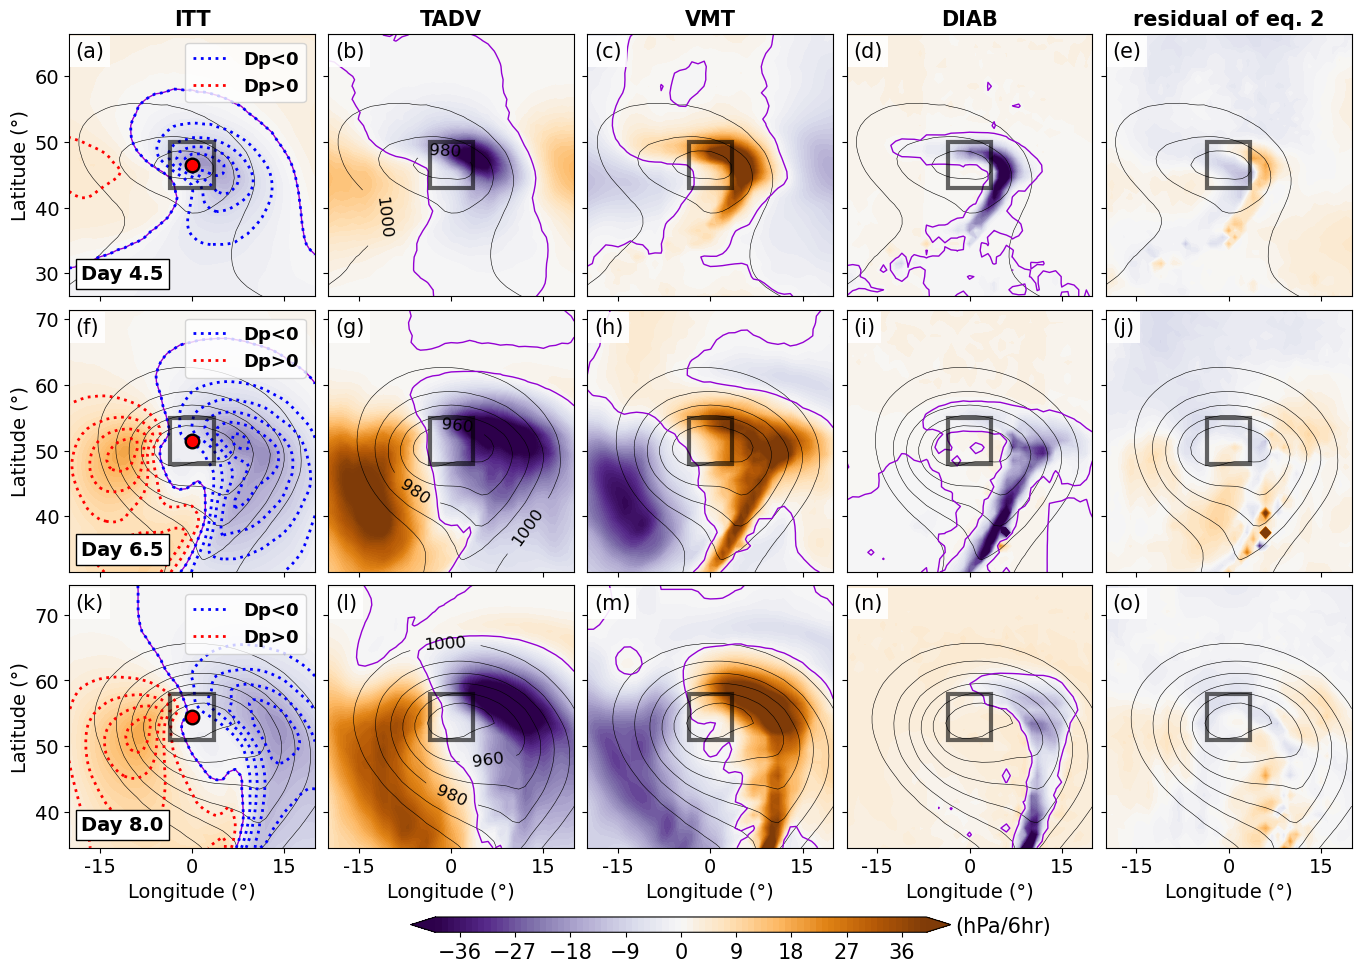

In [13]:
fig = plt.figure(figsize=(13.5,9),layout="constrained")

# set up figure structure
nrows = 3
ncols = 5

gs = GridSpec(nrows, ncols, figure=fig)
ax = np.zeros((nrows,ncols),dtype=object)

for r in range(0,nrows):
    for c in range(0,ncols):
        ax[r,c] = plt.subplot(gs.new_subplotspec((r, c)))
        
# fill with content

clevs_mslp=np.arange(930,1010,10)
clevs_dp_n=np.arange(-24,4,4)
clevs_dp_p=np.arange(4,28,4)

label='[hPa 6hrs-1]'

for r in range(0,nrows):
    
    stp = timesteps[r]
    
    # add mslp to all columns
    
    for c in range(0,ncols):
        cs = ax[r,c].contour(Clons[stp,:],
                         Clats[stp,:],
                         Cmslp[stp,:,:],
                         clevs_mslp,
                         colors='k',
                         linewidths=0.4)
        
        # Add box of aggregated PTE analysis
        
        cen_lat=track_lat[exp][stp+6]
        cen_lon=track_lon[exp][stp+6]
        
        boxsize = 7 # horizontal size of column in deg used for PTE analysis

        ax[r,c].add_patch(plt.Rectangle((cen_lon-boxsize/2,
                                         cen_lat-boxsize/2),
                                        boxsize,
                                        boxsize,
                                       fc='none',
                                        ec='k',
                                        ls='solid',
                                        linewidth=3,
                                       zorder=20,
                                       alpha=0.6))
        
        # features only for first column
        if c==0:
            # provide labels of contours
            #clabels = plt.clabel(cs, levels=[960,980,1000], inline=True,fmt='%1.f', fontsize=8)
    
            #[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
            #for l in clabels:
            #    l.set_rotation(0)
            
            # label of timestep
            xtxt = 0.05
            ytxt = 0.065

            ax[r,c].text(xtxt,
             ytxt,
                 'Day '+str(stp*0.25+2.5),
                 ha='left',
                 weight='bold',
                 fontsize=14,
                         bbox=dict(ec='k',
                                  fc='white'),
                 transform=ax[r,c].transAxes)
            
            # Add marker at cyclone center
            ax[r,c].scatter(cen_lon, cen_lat, c='k', s=110, zorder=20)
            ax[r,c].scatter(cen_lon, cen_lat, c='r', s=50, zorder=20)
          
        if c==1:
            # provide labels of contours
            clabels = plt.clabel(cs, levels=[960,980,1000], inline=True,fmt='%1.f', fontsize=12)
    
            #[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0, alpha=0.8)) for txt in clabels]
            #for l in clabels:
            #    l.set_rotation(0)
    
    # first column: ITT
    c=0
    
    vmax = 40
    clevs = np.arange(-1*vmax,vmax+0.1,1)
    ticks = np.arange(-1*vmax,vmax+0.1,10)
    
    plot_contourf(r,c,
                  Clons[stp,:],
                  Clats[stp,:],
                  Cdp[stp,:,:],
                  clevs,
                  title='ITT',
                  label=None)
    
    
    csn = ax[r,c].contour(Clons[stp,:],
                         Clats[stp,:],
                         Cdp[stp,:,:],
                         clevs_dp_n,
                         colors='blue',
                         linestyles='dotted',
                         linewidths=2)
    
    csp = ax[r,c].contour(Clons[stp,:],
                         Clats[stp,:],
                         Cdp[stp,:,:],
                         clevs_dp_p,
                         colors='red',
                         linestyles='dotted',
                         linewidths=2)
    h1, l1 = csn.legend_elements()
    h2, l1 = csp.legend_elements()
    legend_properties = {'weight':'bold','size' : 13}
    ax[r,c].legend([h1[0],h2[0]], ['Dp<0', 'Dp>0'],loc='upper right',
                   prop=legend_properties)

    # second column: TADV
    c=1    
    
    plot_contourf(r,c,
              Clons[stp,:],
                 Clats[stp,:],
                 Ctadv[stp,:,:],
              clevs,
              title='TADV',
             label=label)
    
    # third column: VMT
    c=2
    
    plot_contourf(r,c,
              Clons[stp,:],
                 Clats[stp,:],
                 Cvmt[stp,:,:],
              clevs,
              title='VMT',
             label=label,
                 ticks=ticks)
    
    # fourth column: DIAB
    c=3
    
    plot_contourf(r,c,
              Clons[stp,:],
                 Clats[stp,:],
                 Cdiab[stp,:,:],
              clevs,
              title='DIAB',
             label=label)
    
    # fifth column: RES
    c=4
    
    plot_contourf(r,c,
              Clons[stp,:],
                 Clats[stp,:],
                 Ceq2res[stp,:,:],
              clevs,
              title='residual of eq. 2',
             label=label,
                 alpha=0)
    
# Set ticks
for r in range(0,nrows):
    for c in range(0,ncols):
        set_xticks(r,c,track_lon[exp],timesteps)

        if r==0:
            ax[r,c].set_yticks([30,40,50,60])
        else:
            ax[r,c].set_yticks([40,50,60,70])

        if r!=nrows-1:
            ax[r,c].set_xticklabels(())
        else:
            ax[r,c].set_xlabel('Longitude (°)',fontsize=14)

        if c!=0:
            ax[r,c].set_yticklabels(())
        else:
            ax[r,c].set_ylabel('Latitude (°)',fontsize=14)
            ax[r,c].tick_params(axis='both', labelsize=14)
            
#plt.subplots_adjust(wspace=0.02,hspace = 0.25)
plt.text(0.027,0.97, '(a)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[0,0].transAxes, fontsize=fontsize, zorder=60) 
plt.text(0.027,0.97, '(b)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[0,1].transAxes, fontsize=fontsize, zorder=60) 
plt.text(0.027,0.97, '(c)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[0,2].transAxes, fontsize=fontsize, zorder=60)
plt.text(0.027,0.97, '(d)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[0,3].transAxes, fontsize=fontsize, zorder=60)
plt.text(0.027,0.97, '(e)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[0,4].transAxes, fontsize=fontsize, zorder=60) 

plt.text(0.027,0.97, '(f)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[1,0].transAxes, fontsize=fontsize, zorder=60) 
plt.text(0.027,0.97, '(g)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[1,1].transAxes, fontsize=fontsize, zorder=60) 
plt.text(0.027,0.97, '(h)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[1,2].transAxes, fontsize=fontsize, zorder=60)
plt.text(0.027,0.97, '(i)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[1,3].transAxes, fontsize=fontsize, zorder=60)
plt.text(0.027,0.97, '(j)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[1,4].transAxes, fontsize=fontsize, zorder=60) 

plt.text(0.027,0.97, '(k)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[2,0].transAxes, fontsize=fontsize, zorder=60) 
plt.text(0.027,0.97, '(l)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[2,1].transAxes, fontsize=fontsize, zorder=60) 
plt.text(0.027,0.97, '(m)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[2,2].transAxes, fontsize=fontsize, zorder=60)
plt.text(0.027,0.97, '(n)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[2,3].transAxes, fontsize=fontsize, zorder=60)
plt.text(0.027,0.97, '(o)', ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax[2,4].transAxes, fontsize=fontsize, zorder=60) 
#plt.text(0, 1.1, '(a)', ha='center', va='top', transform=ax[0,0].transAxes, fontsize=fontsize) 
#plt.text(0, 1.1, '(b)', ha='center', va='top', transform=ax[0,1].transAxes, fontsize=fontsize) 
#plt.text(0, 1.1, '(c)', ha='center', va='top', transform=ax[0,2].transAxes, fontsize=fontsize) 
#plt.text(0, 1.1, '(d)', ha='center', va='top', transform=ax[0,3].transAxes, fontsize=fontsize) 
#plt.text(0, 1.1, '(e)', ha='center', va='top', transform=ax[0,4].transAxes, fontsize=fontsize) 

#figpath = '/work/bb1152/Module_A/A6_CyclEx/figures/drafts/'
figpath = './'
plt.savefig(figpath+'Fig6_PTEsnapshots_CTL_80km_NOtimeavg.png',
                bbox_inches='tight',
                dpi=100)